# Predicting Clothing Size with Regression
Case study based on Rent the Runway dataset  https://www.kaggle.com/rmisra/clothing-fit-dataset-for-size-recommendation#renttherunway_final_data.json

Author: Ng Wei Xuan

In [1]:
#Import libraries
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# Contents
- [Data Cleaning Stage](#section1)
    - [Finalised Dataset](#subsection1.1)
- [Exploratory Data Analysis](#section2)
- [Linear Regression](#section3)
    - [Linear Regression - Model Validation](#subsection3.1)
- [KNN Regression](#section4)
    - [KNN Regression - Model Validation](#subsection4.1)

# Data Cleaning Stage <a id='section1'></a>

<font color=blue> First, we will load the data, explore the data and do some data wrangling so that we can apply our regression models later on.

In [2]:
#import dataset
df_initial = pd.read_json("renttherunway_final_data.json", lines=True)
df_initial.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10.0,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28.0,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10.0,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36.0,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10.0,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116.0,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10.0,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27.0,"September 26, 2016"


<font color=blue> For the purpose of this model, we will only consider the dress category because different clothing types may have different cuttings and sizing conventions which will affect our prediction model.


In [3]:
df_initial = df_initial[df_initial["category"]=="dress"]

df_initial.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
3,fit,909926,34c,126335,135lbs,8.0,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34.0,"February 12, 2014"
5,fit,734848,32b,364092,138lbs,8.0,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45.0,"April 30, 2016"
6,fit,336066,34c,568429,112lbs,10.0,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27.0,"December 7, 2017"
7,fit,86661,34d+,130259,118lbs,10.0,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65.0,"January 1, 2013"
10,small,185966,34b,1077123,135lbs,8.0,party,The dress arrived with a small hole in the bea...,athletic,It was fun to wear a dress I wouldn't normally...,dress,"5' 3""",12,33.0,"January 2, 2018"


In [4]:
#Replace NaN with NA
df_initial = df_initial.fillna("NA")

<font color=blue> The important variables for  predicting clothing size are likely to be physical characteristics such as weight, bust size height. Thus, we will remove records which does not contain these variables.

In [5]:
df_initial = df_initial[(df_initial["weight"] != "NA")]

df_initial = df_initial[(df_initial["height"] != "NA")]

df_initial = df_initial[(df_initial["bust size"] != "NA")]
df_initial.head(5)

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
5,fit,734848,32b,364092,138lbs,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,dress,"5' 8""",8,45,"April 30, 2016"
6,fit,336066,34c,568429,112lbs,10,everyday,This dress is so sweet. I loved the print. The...,hourglass,LITERALLY THE CUTEST DRESS EVER,dress,"5' 3""",4,27,"December 7, 2017"
7,fit,86661,34d+,130259,118lbs,10,formal affair,Fit was great. Maybe a little tight under the ...,full bust,"Great dress, beautifully made. I received lot...",dress,"5' 3""",8,65,"January 1, 2013"
10,small,185966,34b,1077123,135lbs,8,party,The dress arrived with a small hole in the bea...,athletic,It was fun to wear a dress I wouldn't normally...,dress,"5' 3""",12,33,"January 2, 2018"


<font color=blue> We will also filter out the columns which are unlikely to be important predictors of a customer's clothing size

In [6]:
df_initial = df_initial.loc[:,["weight", "height","body type", "size", "fit", "bust size", "category", "age"]]
df_initial.head(5)

,weight,height,body type,size,fit,bust size,category,age
3,135lbs,"5' 5""",pear,8,fit,34c,dress,34
5,138lbs,"5' 8""",athletic,8,fit,32b,dress,45
6,112lbs,"5' 3""",hourglass,4,fit,34c,dress,27
7,118lbs,"5' 3""",full bust,8,fit,34d+,dress,65
10,135lbs,"5' 3""",athletic,12,small,34b,dress,33


<font color=blue> We also realised that the weight column is stored as strings, as seen from examples such as "137lbs". We will do a check on the datatypes to confirm this. We will then convert the data type to integers if that is the case.

In [7]:
df_initial.dtypes

weight       object
height       object
body type    object
size          int64
fit          object
bust size    object
category     object
age          object
dtype: object

In [8]:
#Convert weight to integers
df_initial["Weight in lbs"] = df_initial["weight"].str.slice(0,3)

In [9]:
#If Weight in lbs has length of 5 (eg 90lbs) then we need to slice the 1st 2 characters only
df_initial["Weight Length"] = df_initial["weight"].map(len)
df_initial.loc[df_initial["Weight Length"] == 5,"Weight in lbs"] = df_initial["weight"].str.slice(0,2)
#Set to integer after slicing
df_initial["Weight in lbs"] = df_initial["Weight in lbs"].astype("int32")
df_initial.head(5)

,weight,height,body type,size,fit,bust size,category,age,Weight in lbs,Weight Length
3,135lbs,"5' 5""",pear,8,fit,34c,dress,34,135,6
5,138lbs,"5' 8""",athletic,8,fit,32b,dress,45,138,6
6,112lbs,"5' 3""",hourglass,4,fit,34c,dress,27,112,6
7,118lbs,"5' 3""",full bust,8,fit,34d+,dress,65,118,6
10,135lbs,"5' 3""",athletic,12,small,34b,dress,33,135,6


<font color=blue> The height column is also stored as strings, so we will need to convert them into integers, such as height in centimeters.
I have prepared a table called 'Inches to Centimeter.xlsx' which maps foot and inches to centimeters 

In [10]:
conversion_df = pd.read_excel("Inches to Centimeter.xlsx")
conversion_df

,Feet,Centimeters
0,"4' 0""",121.92
1,"4' 1""",124.46
2,"4' 2""",127.00
3,"4' 3""",129.54
4,"4' 4""",132.08
5,"4' 5""",134.62
6,"4' 6""",137.16
7,"4' 7""",139.70
8,"4' 8""",142.24
9,"4' 9""",144.78


In [11]:
#convert to CM by joining dataframes
df_initial = pd.merge(df_initial, conversion_df, left_on= "height", right_on= "Feet", how="inner")
df_initial.rename(columns={'Centimeters':'Height in CM'}, inplace=True)
df_initial.head(5)

,weight,height,body type,size,fit,bust size,category,age,Weight in lbs,Weight Length,Feet,Height in CM
0,135lbs,"5' 5""",pear,8,fit,34c,dress,34,135,6,"5' 5""",165.1
1,143lbs,"5' 5""",athletic,12,fit,34d,dress,26,143,6,"5' 5""",165.1
2,145lbs,"5' 5""",hourglass,12,fit,36d,dress,33,145,6,"5' 5""",165.1
3,128lbs,"5' 5""",pear,12,fit,34b,dress,32,128,6,"5' 5""",165.1
4,145lbs,"5' 5""",pear,16,fit,34d,dress,29,145,6,"5' 5""",165.1


In [12]:
#We no longer need the weight and height columns which are strings so we filter them out as well

df_initial = df_initial.loc[:,["Height in CM", "Weight in lbs", "body type", "size", "fit", "bust size", "category", "age"]]
df_initial.head(5)

,Height in CM,Weight in lbs,body type,size,fit,bust size,category,age
0,165.1,135,pear,8,fit,34c,dress,34
1,165.1,143,athletic,12,fit,34d,dress,26
2,165.1,145,hourglass,12,fit,36d,dress,33
3,165.1,128,pear,12,fit,34b,dress,32
4,165.1,145,pear,16,fit,34d,dress,29


<font color=blue> The bust size column is also an important predictor. However, it is also stored in a string format, which does not work with a regression model. So we need to convert it into an integer.

According to https://www.blitzresults.com/en/bra-size/, the bust size measurement is split into 2 components, the band size (number) in inches and the cup size (alphabets). Also, for sizes with '/', it can be interpreted as the size with the last character. For example, '36ddd/e' can be interpreted as '36e'

Thus, we need to split size number and cup size (alphabet). For example, "34a" can be split into "34" and "a".

In [13]:
#First, check types of bust size
print(df_initial["bust size"].unique())


['34c' '34d' '36d' '34b' '32c' '34a' '32a' '36c' '32dd' '32b' '34d+' '38d'
 '36dd' '34dd' '32d' '38a' '34ddd/e' '32ddd/e' '38c' '34aa' '40d' '36b'
 '34g' '36ddd/e' '38b' '32d+' '36a' '30g' '34j' '32aa' '42d' '34f' '36d+'
 '38d+' '30a' '38ddd/e' '28a' '28ddd/e' '32h' '36g' '30dd' '44ddd/e' '32f'
 '30c' '30ddd/e' '36f' '42dd' '32g' '38g' '40dd' '38dd' '36h' '46ddd/e'
 '30d' '28b' '38f' '30b' '30aa' '40ddd/e' '40c' '40f' '36aa' '44dd' '30i'
 '32i' '42ddd/e' '28dd' '28c' '40b' '34h' '44c' '44d' '32j' '40h' '36i'
 '42b' '40g' '44g' '30f' '42c' '28g' '30h' '44f' '48dd' '28aa' '28f' '42f'
 '34i' '36j' '38i' '28d' '38h' '38aa' '42g' '44b' '48d']


In [14]:
#Input is the bust size eg 32b, 34c .....
def size_func(x):
    output = ""
    
    #Look for size with "+", if it has a "+", we get rid of the "+"
    if x.find("+") != -1:
        output=x[:-1]
    #Look for size with "/", if it exists the alphabet we are interested in is the last character (after '/')
    elif x.find("/") != -1:  
        output=x[-1]
    else:
        output=x
    
    return output

#To convert all the sizes to upper case
def upper_case(x):
    x = x.upper()
    
    return x

#To convert to string
def to_string(x):
    x = str(x)
    
    return x

def to_float(x):
    x = float(x)
    
    return x

def to_int(x):
    x = int(x)
    
    return(x)

In [15]:
#Split size number and cup size (alphabet)

#first 2 characters are the size number (band size)
df_initial["Band Size"] = df_initial['bust size'].str[:2]

#following characters is the cup size (alphabet)
df_initial["Cup Size"] = df_initial['bust size'].str[2:]
df_initial.head(5)

,Height in CM,Weight in lbs,body type,size,fit,bust size,category,age,Band Size,Cup Size
0,165.1,135,pear,8,fit,34c,dress,34,34,c
1,165.1,143,athletic,12,fit,34d,dress,26,34,d
2,165.1,145,hourglass,12,fit,36d,dress,33,36,d
3,165.1,128,pear,12,fit,34b,dress,32,34,b
4,165.1,145,pear,16,fit,34d,dress,29,34,d


In [16]:
#Get only the alphabet of the cup size and make them upper case

df_initial["Cup Size"]=df_initial["Cup Size"].apply(size_func)
df_initial["Cup Size"]=df_initial["Cup Size"].apply(upper_case)
df_initial["Cup Size"]=df_initial["Cup Size"].apply(to_string)

df_initial.head(5)

,Height in CM,Weight in lbs,body type,size,fit,bust size,category,age,Band Size,Cup Size
0,165.1,135,pear,8,fit,34c,dress,34,34,C
1,165.1,143,athletic,12,fit,34d,dress,26,34,D
2,165.1,145,hourglass,12,fit,36d,dress,33,36,D
3,165.1,128,pear,12,fit,34b,dress,32,34,B
4,165.1,145,pear,16,fit,34d,dress,29,34,D


<font color=blue> Again, I found an excel bust size chart and I will use this to convert to CM.

In [17]:
cup_table = pd.read_excel("bust_size chart.xlsx", sheet_name="Cup Size")
cup_table

,Cup Size,Inch,Size in CM
0,AA,0.8,2.032
1,A,1.0,2.540
2,B,2.0,5.080
3,C,3.0,7.620
4,D,4.0,10.160
5,DD,5.0,12.700
6,E,5.0,12.700
7,DDD,6.0,15.240
8,F,6.0,15.240
9,DDDD,7.0,17.780


In [18]:
#Merge the dataframe to get the Cup Size in CM (called "Size in CM")

df = pd.merge(df_initial,cup_table, left_on="Cup Size", right_on='Cup Size',how="left")
df.head(5)

,Height in CM,Weight in lbs,body type,size,fit,bust size,category,age,Band Size,Cup Size,Inch,Size in CM
0,165.1,135,pear,8,fit,34c,dress,34,34,C,3.0,7.62
1,165.1,143,athletic,12,fit,34d,dress,26,34,D,4.0,10.16
2,165.1,145,hourglass,12,fit,36d,dress,33,36,D,4.0,10.16
3,165.1,128,pear,12,fit,34b,dress,32,34,B,2.0,5.08
4,165.1,145,pear,16,fit,34d,dress,29,34,D,4.0,10.16


In [19]:
df = df[["Height in CM", "Weight in lbs", "bust size","Band Size", "Cup Size","Size in CM", "size","fit"]]
df.head(5)

,Height in CM,Weight in lbs,bust size,Band Size,Cup Size,Size in CM,size,fit
0,165.1,135,34c,34,C,7.62,8,fit
1,165.1,143,34d,34,D,10.16,12,fit
2,165.1,145,36d,36,D,10.16,12,fit
3,165.1,128,34b,34,B,5.08,12,fit
4,165.1,145,34d,34,D,10.16,16,fit


In [20]:
#Convert Bust Size (Numeric) to cm

def size_to_cm(x):
    x = x*2.54
    return x

#Make the column "Size Number" a float
df["Band Size"]=df["Band Size"].apply(to_float)

#Apply inches to cm convertor
df["Band Size in CM"] = df["Band Size"].apply(size_to_cm)

#The bust size in cm will be sum of the 2 columns
df["bust_size_in_cm"] = df["Band Size in CM"] + df["Size in CM"]

#Convert weight to KG
df["Weight in KG"] = df["Weight in lbs"]*0.453592
df.head(5)

,Height in CM,Weight in lbs,bust size,Band Size,Cup Size,Size in CM,size,fit,Band Size in CM,bust_size_in_cm,Weight in KG
0,165.1,135,34c,34.0,C,7.62,8,fit,86.36,93.98,61.234920
1,165.1,143,34d,34.0,D,10.16,12,fit,86.36,96.52,64.863656
2,165.1,145,36d,36.0,D,10.16,12,fit,91.44,101.60,65.770840
3,165.1,128,34b,34.0,B,5.08,12,fit,86.36,91.44,58.059776
4,165.1,145,34d,34.0,D,10.16,16,fit,86.36,96.52,65.770840


# Finalised Dataset <a id='subsection1.1'></a>

<font color=blue> Finally, we arrive at our finalized dataset which we can use.

In [21]:
df = df[["Height in CM", "Weight in KG", "bust_size_in_cm", "fit", "size"]]

#If large, we assume that we should minus 1 to current size 
#If small, we assume that we should add 1 to the current size
#We will use this actual size column to train the data

df.loc[df["fit"]=="large", "Addition_to_Size"] = -1
df.loc[df["fit"]=="small", "Addition_to_Size"] = 1
df.loc[df["fit"]=="fit", "Addition_to_Size"] = 0

#Actual size should be sum of size and addition to size columns
df["size"] = df["size"] + df["Addition_to_Size"]

df.tail(5)

,Height in CM,Weight in KG,bust_size_in_cm,fit,size,Addition_to_Size
72911,190.5,65.77084,91.44,fit,13.0,0.0
72912,190.5,74.84268,96.52,fit,20.0,0.0
72913,190.5,65.77084,91.44,fit,12.0,0.0
72914,190.5,63.50288,91.44,fit,12.0,0.0
72915,190.5,81.64656,96.52,fit,24.0,0.0


# Exploratory Data Analysis <a id='section2'></a>

<font color=blue> From here, we can see that the heights and weights data are reasonable. 
    
 <font color=blue> For instance, there are no obvious errors in the data such as heights and weights being negative.

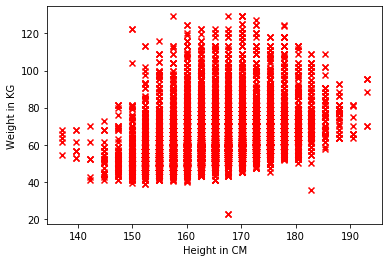

In [22]:
plt.scatter(x=df["Height in CM"], y=df["Weight in KG"], marker="x",c="r", label="residuals")
plt.xlabel("Height in CM")
plt.ylabel("Weight in KG")
plt.show()

<font color=blue> From the histogram, we can also see that the bust size data is reasonable. 

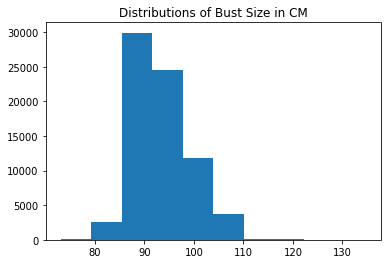

In [23]:
plt.hist(df["bust_size_in_cm"])
plt.title("Distributions of Bust Size in CM")
plt.show()

<font color=blue>

We will now proceed to implement a linear regression model

# Linear Regression <a id='section3'></a>

<font color=blue> The linear regression model is represented by the equation Y = A + B1X1 + B2X2 + B3X3 + ..... + (Bk)Xk

Y represents the target variable, which is the variable "size" in our case.

The X are known as the predictor variables, which will be "Height in CM", "Weight in KG" and "bust size in cm"

A refers to the axis intercept.

<font color=blue> First, we will set up an annova table to test the significance of our predictor variables by looking at their p values

In [24]:
df.rename(columns={'Height in CM':'Height_in_CM', "Weight in KG":"Weight_in_KG"}, inplace=True)
results = smf.ols('size ~ Height_in_CM + Weight_in_KG + bust_size_in_cm', data=df).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   size   R-squared:                       0.718
Model:                            OLS   Adj. R-squared:                  0.718
Method:                 Least Squares   F-statistic:                 6.191e+04
Date:                Sun, 24 May 2020   Prob (F-statistic):               0.00
Time:                        10:53:01   Log-Likelihood:            -2.0646e+05
No. Observations:               72916   AIC:                         4.129e+05
Df Residuals:                   72912   BIC:                         4.130e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -34.7158      0.514    -

<font color=blue>From here, by looking at the  P>| t | column, we can see that the p-values of our variables are all 0, which means they are variables are necessary in our regression model for predicting the clothes size.

We will now proceed to implement the linear regression model with sklearn. </font>

In [25]:
#Convert X values from dataframe to arrays

#Sci-Kit Learn does not accept Series or Dataframes as arguments, so we need to convert them into arrays
X = df.iloc[:,0:3].values
X

array([[165.1     ,  61.23492 ,  93.98    ],
       [165.1     ,  64.863656,  96.52    ],
       [165.1     ,  65.77084 , 101.6     ],
       ...,
       [190.5     ,  65.77084 ,  91.44    ],
       [190.5     ,  63.50288 ,  91.44    ],
       [190.5     ,  81.64656 ,  96.52    ]])

In [26]:
#Convert Y Values from dataframe to arrays
y = df['size'].values
y

array([ 8., 12., 12., ..., 12., 12., 24.])

<font color=blue> We will now use train test split to split our dataset into training and test data. 

We will fit the model using the train data. 

With this fitted model, we will attempt to predict the values from the train data

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print(X_train.shape)
print(X_test.shape)

(58332, 3)
(14584, 3)


In [28]:
reg = LinearRegression().fit(X_train, y_train)
prediction = reg.predict(X_test)

#prediction = np.round(prediction, 0)

#Sizes cannot be in float, so we will convert them to integers
prediction = prediction.astype(int)
print(prediction)

[10  8 10 ...  8  8 20]


In [29]:
#Regression Coefficient
coefficients = reg.coef_
print("Coefficients: ", coefficients)

Coefficients:  [-0.09739006  0.58285523  0.2814579 ]


In [30]:
intercept = reg.intercept_ 
print("Intercept = ", intercept)

Intercept =  -35.19202680530446


# Linear Regression - Model Validation <a id='subsection3.1'></a>

<font color=blue> Now, we will evaluate the model

First, we look at the R Squared Score. A R Squared Score ranges from 0 to 1, with 1 being a perfect prediction.

We can also measure the Root of Mean Squared Error (RMSE).


In [31]:
score_r2 = r2_score(y_test, prediction)

print("r2 score (out of 1.0) = ", "{0:4.3f}".format(score_r2))

MSE = np.sqrt(mean_squared_error(y_test, prediction))

print("RMSE = ", "{0:4.3f}".format(MSE))

r2 score (out of 1.0) =  0.720
RMSE =  4.110


<font color=blue> We can also visualise our prediction by plotting the predicted values and the actual values from the train data. The vertical distance between the red and blue scatter are the residuals.

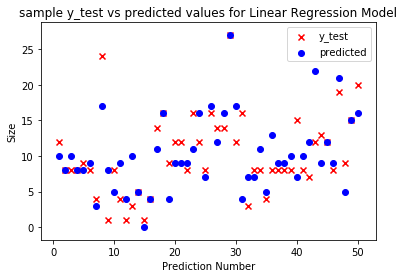

In [32]:
#Visualise results

#Predicted values = prediction
#Comparing values = y _test

a = 51

list_of_prediction = []
y_test = np.array(y_test)
#print(y_test)
prediction = np.array(prediction)
#print(prediction)
length_y = len(y_test)
length_predict = len(prediction)


for i in range(1,a):
    list_of_prediction.append(i)
    
#print(len(list_of_prediction))

y_test_1 = y_test[0:a-1]
#print(len(y_test))
prediction_1 = prediction[0:a-1]

plt.scatter(x=list_of_prediction, y=y_test_1, marker="x",c="r", label="y_test")
plt.scatter(x=list_of_prediction, y=prediction_1, marker="o",c="b", label="predicted")
plt.xlabel("Prediction Number")
plt.ylabel("Size")
plt.legend()
plt.title("sample y_test vs predicted values for Linear Regression Model")
plt.show()

<font color=blue> We can also visualise the residuals. 

14584
14584


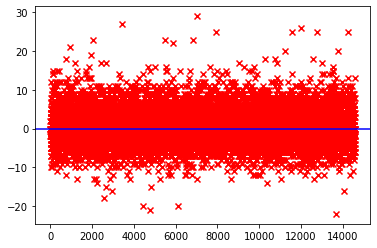

In [33]:
residuals = y_test - prediction
list_of_prediction_2 = []
print(len(residuals))

for i in range(len(residuals)):
    list_of_prediction_2.append(i)
print(len(list_of_prediction_2))
plt.axhline(y=0, color='b', linestyle='-')

plt.scatter(x=list_of_prediction_2, y=residuals, marker="x",c="r", label="residuals")
plt.show()

<font color=blue> Next, we will also evaluate the model using cross-validation.

In [34]:
linear_reg = LinearRegression()
print(linear_reg)
X = df.iloc[:,0:3].values
y = df['size'].values
cross_val_results = cross_validate(linear_reg, X, y, cv=10)
cross_val_results = cross_val_results['test_score']
print(cross_val_results)
print(" ")
print("Accuracy: %0.3f (+/- %0.3f)" % (cross_val_results.mean(), cross_val_results.std() * 2))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
[0.71114482 0.70812014 0.7180984  0.69883675 0.70739647 0.70889921
 0.70105205 0.72017519 0.6998859  0.73506938]
 
Accuracy: 0.711 (+/- 0.021)


<font color=blue> We can see that the accuracy of this model is around 71.1%. However, can the prediction accuracy be even higher?
    
<font color=blue> We will now consider another form of regression, the KNN Regression, which may provide a higher prediction accuracy

# KNN Regression <a id='section4'></a>

In [35]:
#Convert X and Y into arrays
X = df.iloc[:,0:3].values

y = df['size'].values

#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [36]:
#Check K Value
#Plot K Value VS RMSE 

rmse_list = [] #to store rmse values for different k
K_values = []
for K in range(1,101):
    
    K_values.append(K)
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = np.sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_list.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

print(" ")


min_rmse = min(rmse_list)
min_rmse_pos = rmse_list.index(min_rmse)
K_min = K_values[min_rmse_pos]

print("Min Value of RMSE = ", "{0:4.3f}".format(min_rmse))
print("K Value at Minimum RMSE = ", K_min)

RMSE value for k=  1 is: 5.656914855549817
RMSE value for k=  2 is: 4.858484867291951
RMSE value for k=  3 is: 4.569030109674223
RMSE value for k=  4 is: 4.459845050644053
RMSE value for k=  5 is: 4.3551780015429244
RMSE value for k=  6 is: 4.288354471929575
RMSE value for k=  7 is: 4.240153529736355
RMSE value for k=  8 is: 4.212375888542161
RMSE value for k=  9 is: 4.184375221089895
RMSE value for k=  10 is: 4.164876942377213
RMSE value for k=  11 is: 4.148189250430155
RMSE value for k=  12 is: 4.137877146406472
RMSE value for k=  13 is: 4.127598561646178
RMSE value for k=  14 is: 4.117441424360094
RMSE value for k=  15 is: 4.112906314804769
RMSE value for k=  16 is: 4.108070545142065
RMSE value for k=  17 is: 4.103235606227735
RMSE value for k=  18 is: 4.100115105781873
RMSE value for k=  19 is: 4.090838033018177
RMSE value for k=  20 is: 4.089344228329636
RMSE value for k=  21 is: 4.087717494290569
RMSE value for k=  22 is: 4.083755700198698
RMSE value for k=  23 is: 4.085120131249

<font color=blue> We will now plot the 'elbow curve' of RMSE values over different K values in order to find the K value that gives us  the lowest RMSE.

Text(0, 0.5, 'RMSE')

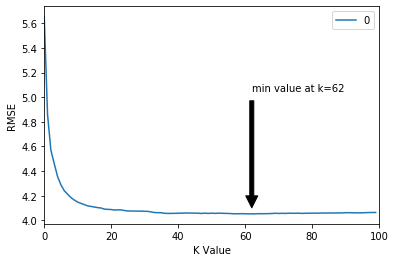

In [37]:
rmse_values = pd.DataFrame(rmse_list) #elbow curve 
ymin = min(rmse_list)


ax = rmse_values.plot()

xpos = rmse_list.index(min_rmse)
xmax = K_values[xpos]
max_K = max(K_values)

K_min = str(K_min)
ax.annotate('min value at k='+ K_min, xy=(xmax, ymin), xytext=(xmax, ymin+1),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )

ax.set_xlim(0,max_K)
plt.xlabel("K Value")
plt.ylabel("RMSE")

<font color=blue> Now, we implement the KNN Regression Model

In [38]:
K_min = int(K_min)
print("K Value used = ", K_min)
model = KNeighborsRegressor(n_neighbors=K_min)
model_fit = model.fit(X_train,y_train)
predict = model_fit.predict(X_test)
#predict = np.round(predict, 0)
predict = predict.astype(int)
print(predict)
print(len(predict))

K Value used =  62
[11  6  9 ...  6  7 19]
14584


# KNN Regression - Model Validation <a id='subsection4.1'></a>

In [39]:
KNN_Reg = KNeighborsRegressor(n_neighbors=K_min)
X = df.iloc[:,0:3].values
y = df['size'].values
cross_val_results = cross_validate(KNN_Reg, X, y, cv=10) #return_train_score=True)
cross_val_results = cross_val_results['test_score']
print(cross_val_results)
print(" ")
print("Accuracy: %0.3f (+/- %0.2f)" % (cross_val_results.mean(), cross_val_results.std() * 2))

[0.71181851 0.70708226 0.7213622  0.70421112 0.71494112 0.71379763
 0.69966404 0.72270111 0.70590931 0.73122311]
 
Accuracy: 0.713 (+/- 0.02)


<font color=blue> From here, the prediction accuracy of the KNN Regression model is around 71.3%, which is slightly better than our linear regression model.

<font color=blue> Hence, this means that on average, the model will recommend the correct size to the 71.3% of the customers.
    
<font color=blue> However, we should be aware that this model assumes that in the initial dataset, when customers gives feedback that their dress is too large, the actual size will be 1 size smaller. On the other hand, when the customer gives feedback that their dress is too small, the actual size will be 1 size larger. In reality, this assumption might not always be true. For instance, the actual size might be 2 or 3 size larger or smaller. 
    
<font color=blue>To improve on this model, further feedback can be collected from the customer, such as asking the customer to suggest how many sizes larger or smaller it should be. This can then become the basis for us to recompute the "Addition_to_Size" column to improve the model.